#### Import das Bicliotecas

In [1]:
import re
import nltk
import spacy
import unicodedata
import numpy    as np
import pandas   as pd
import seaborn  as sns
import matplotlib.pyplot    as plt

from itertools      import combinations
from itertools      import chain
from nltk.stem      import RSLPStemmer
from wordcloud      import WordCloud
from nltk.corpus    import stopwords
from collections    import Counter
from sklearn.feature_extraction.text    import CountVectorizer


#### Configurações gerais

In [2]:
# Configuração do Pandas para exibir todas as colunas
pd.set_option('display.max_columns', None)

# Congigurando para mostrar 2 casas decimais
pd.set_option('display.float_format', '{:.2f}'.format)

# Carregando o modelo de spaCy
nlp = spacy.load("pt_core_news_md")

# Download de recursos do NLTK
nltk.download('stopwords')
nltk.download('rslp')
stop_words = set(stopwords.words('portuguese'))
stemmer = RSLPStemmer()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\marci\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package rslp to
[nltk_data]     C:\Users\marci\AppData\Roaming\nltk_data...
[nltk_data]   Package rslp is already up-to-date!


#### Funções

In [ ]:
# Normaliza o texto de uma coluna, removendo acentuação, caracteres especiais e formatando como maiúsculas.
def normalizar_colunas(name: str) -> str:
    nfkd = unicodedata.normalize("NFKD", name)
    sem_acentos = "".join([c for c in nfkd if not unicodedata.combining(c)])
    substituido = re.sub(r"[^\w]+", "_", sem_acentos)
    colapsado = re.sub(r"_{2,}", "_", substituido)
    return colapsado.strip("_").upper()

# Normaliza qualquer valor, removendo acentuação, caracteres especiais e formatando como maiúsculas.
def normalizar_valores(val: object) -> object:
    """
    Recebe qualquer valor e retorna:
      1) Se não for string (ou for NaN), retorna o valor original.
      2) Se for string, remove acentos, substitui não alfanuméricos por "_", remove "_" no início/fim,
         colapsa múltiplos "_" e retorna em maiúsculas.
    """
    if pd.isna(val):
        return val
    if not isinstance(val, str):
        val = str(val)
    
    val_nfkd = unicodedata.normalize("NFKD", val)
    sem_acentos = "".join([c for c in val_nfkd if not unicodedata.combining(c)])
    
    substituido = re.sub(r"[^\w]+", "_", sem_acentos)
    colapsado = re.sub(r"_{2,}", "_", substituido)
    
    resultado = colapsado.strip("_").lower()
    
    return resultado

# Plota o gráfico de barras vertical
def plot_bar_vert(
    df
    ,coluna_x
    ,coluna_y
    ,xlabel=""
    ,ylabel=""
    ,titulo=""
    ,top_n=10
    ,figsize=(10, 6)
    ,inverter_ys=True
):
    df_top = df.sort_values(by=coluna_x, ascending=False).head(top_n)
    df_top = df_top[::-1] 

    plt.figure(figsize=figsize)
    bars = sns.barplot(
        x=df_top[coluna_x],
        y=df_top[coluna_y],
        palette="viridis"
    )
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(titulo)

    # Adiciona rótulos formatados como 00.0K
    for bar in bars.patches:
        width = bar.get_width()
        plt.text(
            width + max(df_top[coluna_x]) * 0.01,
            bar.get_y() + bar.get_height() / 2,
            f"{width/1000:5.1f}K",
            va="center",
            ha="left",
            fontsize=10
        )

    if inverter_ys:
        plt.gca().invert_yaxis()

    plt.tight_layout()
    plt.show()

# Plota graficos de texto, incluindo histogramas e word clouds
def plot_frases(frases):
    # Contagem de frequência das frases
    contagem = Counter(frases)
    frases_comuns = contagem.most_common(20)  # Top 20 frases

    # Plot do histograma
    plt.figure(figsize=(10, 6))
    bars = sns.barplot(
        x=[freq for frase, freq in frases_comuns],
        y=[frase for frase, freq in frases_comuns],
        palette="viridis"
    )
    plt.xlabel("Frequência")
    plt.ylabel("Frases")
    plt.title("Top 20 Frases Mais Frequentes")

    for bar, (frase, freq) in zip(bars.patches, frases_comuns):
        plt.text(
            bar.get_width() + max([freq for _, freq in frases_comuns]) * 0.01,
            bar.get_y() + bar.get_height() / 2,
            f"{freq/1000:.1f}k",
            va="center",
            ha="left",
            fontsize=10
        )

    plt.show()
    
    # WordCloud
    wordcloud = WordCloud(width=800, height=400, background_color="white").generate(" ".join(frases))
    plt.figure(figsize=(12, 6))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title("WordCloud das Frases")
    plt.show()

# Função para extrair “noun chunks” e “noun+adj chunks” usando spaCy
def extrair_frases(text, min_freq=5):
    """
    Recebe uma string 'text', normaliza e retorna as frases (chunks) mais relevantes dentro desse texto, segundo spaCy.
    """
    # Normalização: remove underscores, símbolos, stopwords e converte para minúsculas
    if pd.isna(text):
        return []
    
    normalized_text = text.replace("_", " ")
    
    # Processamento com spaCy
    doc = nlp(normalized_text)
    phrases = []
    for chunk in doc.noun_chunks:
        length = len(chunk)
        if 2 <= length <= 5:
            lemmas = [token.lemma_ for token in chunk if not token.is_stop and not token.is_punct]
            if lemmas:
                phrases.append(" ".join(lemmas))
    return phrases

# Função para formatar valores grandes
def formatar_valor(valor):
    if valor >= 1e6:
        return f'{valor/1e6:.1f}M'
    elif valor >= 1e3:
        return f'{valor/1e3:.1f}K'
    else:
        return str(valor)


#### Leitura e tratamento dos dados

In [4]:
# Carregando o arquivo CSV
df = pd.read_csv(
    "datatran2024.csv"
    ,sep=";"
    ,quotechar='"'
    ,encoding="latin1"
    ,engine="python"
)

In [5]:
# Aplicando a normalização às colunas do DataFrame
df.columns = [normalizar_colunas(col) for col in df.columns]

In [6]:
# Ajuste de tipos de dados
df["DATA_INVERSA"] = pd.to_datetime(df["DATA_INVERSA"], format="%d/%m/%Y", errors="coerce")
df["HORARIO"] = pd.to_datetime(df["HORARIO"], format="%H:%M:%S", errors="coerce").dt.time
df["BR"] = df["BR"].astype(str)

# Cria coluna de hora para ser usada em análise
df['HORA'] = df['HORARIO'].astype(str).str[:2].astype(int)


In [7]:
# Normaliza o valor de uma célula, removendo acentuação, caracteres especiais e formatando como maiúsculas.
for col in df.columns:
    if df[col].dtype == "object" and col != "HORARIO":
        df[col] = df[col].apply(normalizar_valores)

In [8]:
df.head()

,ID,DATA_INVERSA,DIA_SEMANA,HORARIO,UF,BR,KM,MUNICIPIO,CAUSA_ACIDENTE,TIPO_ACIDENTE,CLASSIFICACAO_ACIDENTE,FASE_DIA,SENTIDO_VIA,CONDICAO_METEREOLOGICA,TIPO_PISTA,TRACADO_VIA,USO_SOLO,PESSOAS,MORTOS,FERIDOS_LEVES,FERIDOS_GRAVES,ILESOS,IGNORADOS,FERIDOS,VEICULOS,LATITUDE,LONGITUDE,REGIONAL,DELEGACIA,UOP,HORA
0,571789,2024-01-01,segunda_feira,03:56:00,es,101,38,conceicao_da_barra,ultrapassagem_indevida,colisao_lateral_sentido_oposto,NaN,plena_noite,crescente,ceu_claro,simples,reta,nao,3,0,0,1,1,1,1,3,18_48261,39_92379,sprf_es,del04_es,uop02_del04_es,3
1,571804,2024-01-01,segunda_feira,04:50:00,pi,343,185,piripiri,manobra_de_mudanca_de_faixa,colisao_frontal,com_vitimas_fatais,amanhecer,decrescente,ceu_claro,simples,reta,sim,2,1,0,0,1,0,0,2,4_29603281,41_76732659,sprf_pi,del02_pi,uop01_del02_pi,4
2,571806,2024-01-01,segunda_feira,04:30:00,ba,116,578,brejoes,ingestao_de_alcool_pelo_condutor,colisao_frontal,com_vitimas_fatais,plena_noite,decrescente,ceu_claro,simples,curva,nao,3,1,0,0,1,2,0,4,13_07158302,39_9611107,sprf_ba,del03_ba,uop02_del03_ba,4
3,571818,2024-01-01,segunda_feira,06:30:00,se,101,18,malhada_dos_bois,reacao_tardia_ou_ineficiente_do_condutor,saida_de_leito_carrocavel,com_vitimas_feridas,amanhecer,crescente,ceu_claro,dupla,declive_reta,nao,2,0,0,1,0,2,1,3,10_35601949,36_90552235,sprf_se,del02_se,uop02_del02_se,6
4,571838,2024-01-01,segunda_feira,05:00:00,mt,364,240,rondonopolis,condutor_deixou_de_manter_distancia_do_veiculo...,colisao_traseira,sem_vitimas,pleno_dia,crescente,ceu_claro,dupla,reta,nao,3,0,0,0,2,1,0,3,16_17914141,54_78905337,sprf_mt,del02_mt,uop01_del02_mt,5


# 1.0 Frequência de Tipos de Acidente

In [9]:
# Verificando os valores únicos na coluna TIPO_ACIDENTE
sorted(df['TIPO_ACIDENTE'].unique().tolist())


['atropelamento_de_animal',
 'atropelamento_de_pedestre',
 'capotamento',
 'colisao_com_objeto',
 'colisao_frontal',
 'colisao_lateral_mesmo_sentido',
 'colisao_lateral_sentido_oposto',
 'colisao_transversal',
 'colisao_traseira',
 'derramamento_de_carga',
 'engavetamento',
 'eventos_atipicos',
 'incendio',
 'queda_de_ocupante_de_veiculo',
 'saida_de_leito_carrocavel',
 'sinistro_pessoal_de_transito',
 'tombamento']

In [43]:
# Calcular frequência absoluta e percentual de cada tipo de acidente
freq_tipo = df['TIPO_ACIDENTE'].value_counts(dropna=False).reset_index()
freq_tipo.columns = ['TIPO_ACIDENTE', 'QTD']
freq_tipo['% TP_ACIDE'] = ((freq_tipo['QTD'] / freq_tipo['QTD'].sum()) * 100).apply(lambda x: f"{x:.2f}%")

# Frequência 
freq_tipo

,TIPO_ACIDENTE,QTD,% TP_ACIDE
0,colisao_traseira,11638,19.28%
1,saida_de_leito_carrocavel,8791,14.56%
2,colisao_transversal,7761,12.86%
3,colisao_lateral_mesmo_sentido,6546,10.84%
4,tombamento,5311,8.80%
5,colisao_com_objeto,4140,6.86%
6,colisao_frontal,3951,6.55%
7,queda_de_ocupante_de_veiculo,2807,4.65%
8,atropelamento_de_pedestre,2661,4.41%
9,colisao_lateral_sentido_oposto,1663,2.75%


C:\Users\marci\AppData\Local\Temp\ipykernel_22244\3374294824.py:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.barplot(


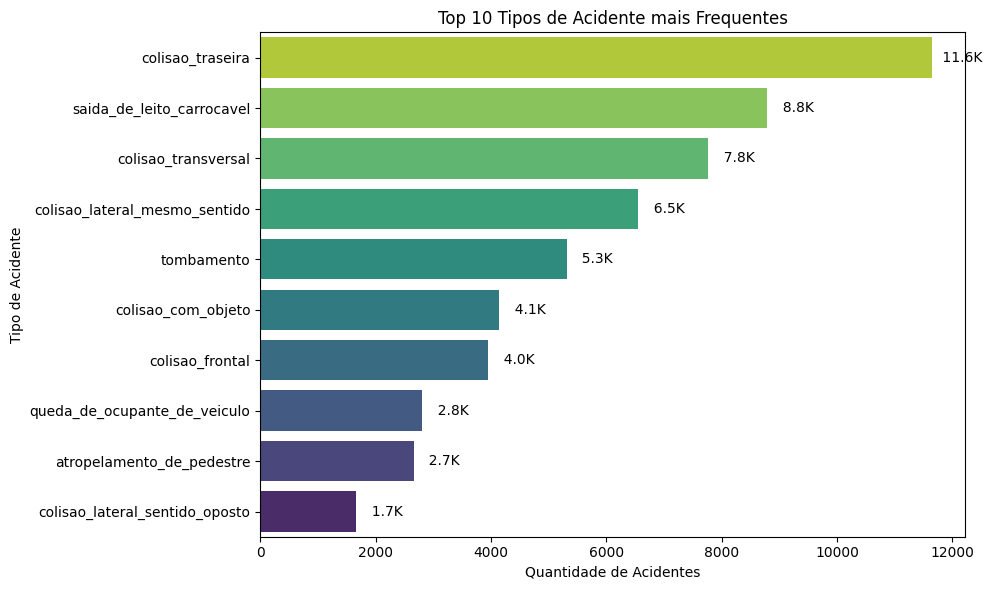

In [44]:
plot_bar_vert(
    df=freq_tipo,
    coluna_y="TIPO_ACIDENTE",
    coluna_x="QTD",
    xlabel="Quantidade de Acidentes",
    ylabel="Tipo de Acidente",
    titulo="Top 10 Tipos de Acidente mais Frequentes",
    top_n=10,
    figsize=(10, 6),
    inverter_ys=True
)


# 1.1 Proporção de Acidentes Fatais, com Feridos e sem Vítimas

In [12]:
# Verificando os valores únicos na coluna CLASSIFICACAO_ACIDENTE
sorted(df['CLASSIFICACAO_ACIDENTE'].dropna().unique().tolist())

['com_vitimas_fatais', 'com_vitimas_feridas', 'sem_vitimas']

In [13]:
# Proporção de acidentes por classificação de gravidade
freq_gravidade = df['CLASSIFICACAO_ACIDENTE'].value_counts().reset_index()
freq_gravidade.columns = ['CLASSIFICACAO_ACIDENTE', 'QTD']
freq_gravidade['% GRAVIDADE'] = ((freq_gravidade['QTD'] / freq_gravidade['QTD'].sum()) * 100).apply(lambda x: f"{x:.2f}%")

# Frequência
freq_gravidade

,CLASSIFICACAO_ACIDENTE,QTD,% GRAVIDADE
0,com_vitimas_feridas,46299,76.70%
1,sem_vitimas,9768,16.18%
2,com_vitimas_fatais,4297,7.12%


# 2.0 Relação entre Condições Meteorológicas e Gravidade dos Acidentes

In [14]:
# Verificando os valores únicos na coluna CONDICAO_METEREOLOGICA
sorted(df['CONDICAO_METEREOLOGICA'].dropna().unique().tolist())

['ceu_claro',
 'chuva',
 'garoa_chuvisco',
 'granizo',
 'ignorado',
 'neve',
 'nevoeiro_neblina',
 'nublado',
 'sol',
 'vento']

In [ ]:
# Tabela de contingência: condicao_metereologica vs gravidade
tab_mc_grav = df.groupby('CONDICAO_METEREOLOGICA').agg({
    'ILESOS': 'sum',
    'FERIDOS_LEVES': 'sum',
    'FERIDOS_GRAVES': 'sum',
    'MORTOS': 'sum'
})

tab_mc_grav = tab_mc_grav.rename(columns={
    'ILESOS': 'sem_vitimas',
    'FERIDOS_LEVES': 'feridos_leves',
    'FERIDOS_GRAVES': 'feridos_graves',
    'MORTOS': 'com_vitimas_fatais'
})

tab_mc_grav['com_vitimas_feridas'] = (
    tab_mc_grav['feridos_leves'] + tab_mc_grav['feridos_graves']
)

tab_mc_grav = tab_mc_grav[['sem_vitimas', 'com_vitimas_feridas', 'com_vitimas_fatais']]

tab_percent = tab_mc_grav.div(tab_mc_grav.sum(axis=1), axis=0) * 100

# Mostrando as 10 primeiras linhas de cada
# print("Tabela Absoluta:")
# tab_mc_grav.head(10)

print("\nTabela Percentual:")
tab_percent.head(10)




Tabela Percentual:


,sem_vitimas,com_vitimas_feridas,com_vitimas_fatais
CONDICAO_METEREOLOGICA,,,
ceu_claro,46.33,49.90,3.76
chuva,43.16,53.28,3.56
garoa_chuvisco,47.28,50.08,2.64
granizo,25.00,75.00,0.00
ignorado,39.59,53.45,6.97
neve,50.00,50.00,0.00
nevoeiro_neblina,42.92,52.13,4.95
nublado,45.50,51.04,3.46
sol,45.85,51.43,2.72


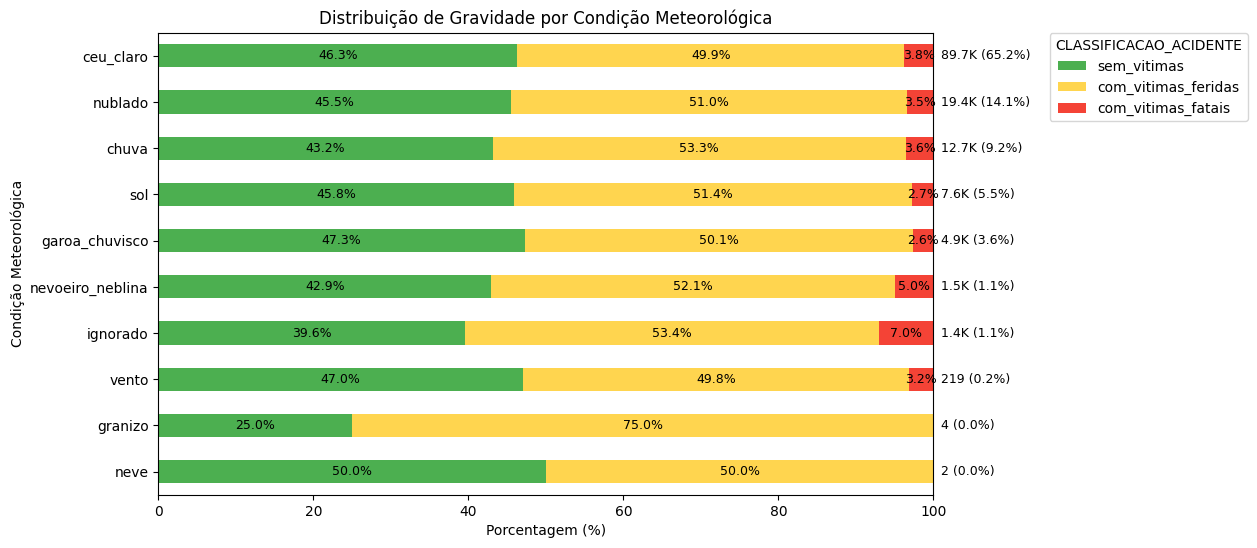

<Figure size 50000x70000 with 0 Axes>

In [ ]:
# Soma dos dados conforme solicitado
tab_mc_grav = df.groupby('CONDICAO_METEREOLOGICA').agg({
    'ILESOS': 'sum',
    'FERIDOS_LEVES': 'sum',
    'FERIDOS_GRAVES': 'sum',
    'MORTOS': 'sum'
})

tab_mc_grav = tab_mc_grav.rename(columns={
    'ILESOS': 'sem_vitimas',
    'FERIDOS_LEVES': 'feridos_leves',
    'FERIDOS_GRAVES': 'feridos_graves',
    'MORTOS': 'com_vitimas_fatais'
})

tab_mc_grav['com_vitimas_feridas'] = (
    tab_mc_grav['feridos_leves'] + tab_mc_grav['feridos_graves']
)

tab_mc_grav = tab_mc_grav[['sem_vitimas', 'com_vitimas_feridas', 'com_vitimas_fatais']]

tab_percent = tab_mc_grav.div(tab_mc_grav.sum(axis=1), axis=0) * 100

totais_abs = tab_mc_grav.sum(axis=1)
total_geral = totais_abs.sum()
percentuais_totais = (totais_abs / total_geral) * 100

tab_percent['Total'] = totais_abs
tab_percent = tab_percent.sort_values(by='Total', ascending=True)
totais_abs = tab_percent['Total']
percentuais_totais = (totais_abs / total_geral) * 100
tab_percent = tab_percent.drop(columns=['Total'])

# Paleta de cores
cores = {
    'sem_vitimas': '#4CAF50',
    'com_vitimas_feridas': '#FFD54F',
    'com_vitimas_fatais': '#F44336'
}

ax = tab_percent.plot(
    kind='barh',
    stacked=True,
    figsize=(10, 6),
    color=[cores[col] for col in tab_percent.columns]
)

plt.xlabel('Porcentagem (%)')
plt.ylabel('Condição Meteorológica')
plt.title('Distribuição de Gravidade por Condição Meteorológica')

# Adicionando rótulos internos e totais absolutos ao lado
for i, (index, row) in enumerate(tab_percent.iterrows()):
    cumulative = 0
    for col in tab_percent.columns:
        width = row[col]
        if width > 0:
            ax.text(
                cumulative + width / 2,
                i,
                f'{width:.1f}%',
                ha='center', va='center', fontsize=9, color='black'
            )
            cumulative += width

    total_abs = totais_abs[index]
    percentual_total = percentuais_totais[index]
    ax.text(
        101,
        i,
        f'{formatar_valor(total_abs)} ({percentual_total:.1f}%)',
        ha='left', va='center', fontsize=9, color='black'
    )

plt.xlim(0, 100)

plt.legend(
    title='CLASSIFICACAO_ACIDENTE',
    bbox_to_anchor=(1.15, 1),
    loc='upper left',
    borderaxespad=0.0
)

plt.figure(figsize=(500, 700))

plt.tight_layout()
plt.show()


# 2.1 Fatores Horário do Acidente e Tipo de Pista

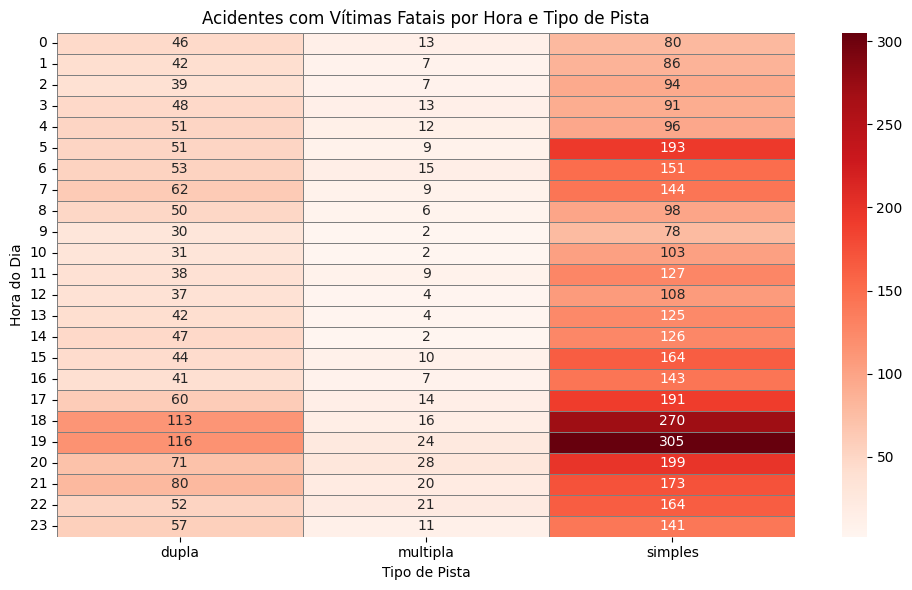

In [26]:
df_fatais = df[df['CLASSIFICACAO_ACIDENTE'] == 'com_vitimas_fatais'].copy()

heatmap_data = df_fatais.pivot_table(
    index='HORA',
    columns='TIPO_PISTA',
    values='MORTOS',
    aggfunc='sum',
    fill_value=0
)

# plot
plt.figure(figsize=(10, 6))
sns.heatmap(
    heatmap_data,
    annot=True,
    fmt='d',
    cmap='Reds',
    linewidths=0.5,
    linecolor='gray'
)

plt.title('Acidentes com Vítimas Fatais por Hora e Tipo de Pista')
plt.ylabel('Hora do Dia')
plt.xlabel('Tipo de Pista')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


C:\Users\marci\AppData\Local\Temp\ipykernel_22244\1327713052.py:7: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  heatmap_data = df_fatais.pivot_table(


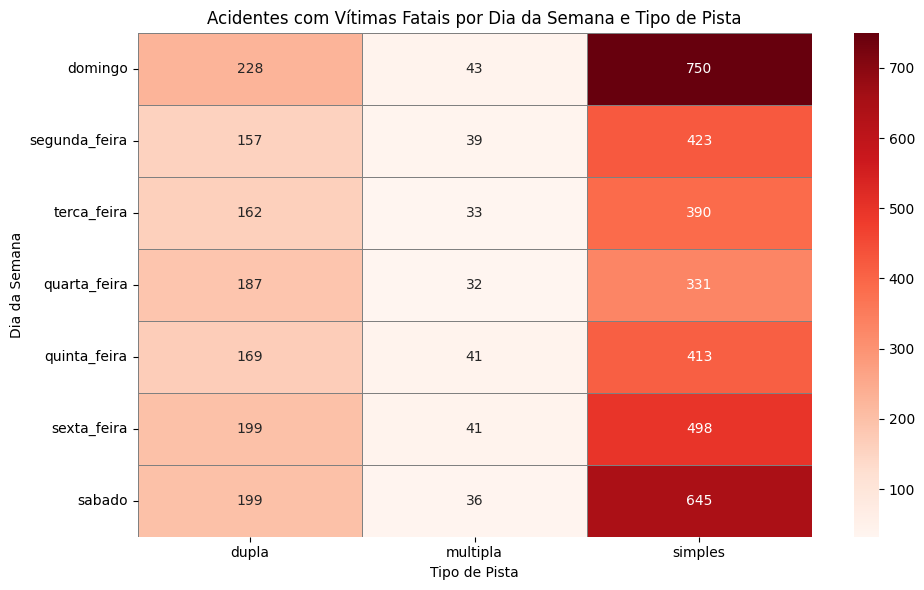

In [ ]:
# plot por dia da semana
df_fatais = df[df['CLASSIFICACAO_ACIDENTE'] == 'com_vitimas_fatais'].copy()
ordem_dias = ['domingo', 'segunda_feira', 'terca_feira', 'quarta_feira', 'quinta_feira', 'sexta_feira', 'sabado']
df_fatais['DIA_SEMANA'] = pd.Categorical(df_fatais['DIA_SEMANA'], categories=ordem_dias, ordered=True)

heatmap_data = df_fatais.pivot_table(
    index='DIA_SEMANA',
    columns='TIPO_PISTA',
    values='MORTOS',
    aggfunc='sum',
    fill_value=0
)

# Plot
plt.figure(figsize=(10, 6))
sns.heatmap(
    heatmap_data,
    annot=True,
    fmt='d',
    cmap='Reds',
    linewidths=0.5,
    linecolor='gray'
)

plt.title('Acidentes com Vítimas Fatais por Dia da Semana e Tipo de Pista')
plt.ylabel('Dia da Semana')
plt.xlabel('Tipo de Pista')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()



# 3.0 Análise de Texto das Causas de Acidentes

In [ ]:
# DataFrame para acientes filtrado com vítimas fatais
# df_fatais = df[df['CLASSIFICACAO_ACIDENTE'] == 'com_vitimas_fatais'].copy()
df_fatais = df.copy()

todas_frases = []
for texto in df_fatais["CAUSA_ACIDENTE"].tolist():
    todas_frases.extend(extrair_frases(texto))

phrase_counts = pd.DataFrame.from_records(
    Counter(todas_frases).most_common(), columns=["FRASE", "QTDE"]
)

MIN_FREQ = 5
phrase_counts = phrase_counts[phrase_counts["QTDE"] >= MIN_FREQ].reset_index(drop=True)

print("Top frases extraídas (spaCy noun_chunks e lemas) com freq ≥ {}:\n".format(MIN_FREQ))
print(phrase_counts.head(20))


Top frases extraídas (spaCy noun_chunks e lemas) com freq ≥ 5:

                        FRASE  QTDE
0   reacao tardio ineficiente  9000
1                    presenca  5823
2                         via  5768
3                     veiculo  5768
4     velocidade incompativel  3475
5     falha mecanico eletrico  2840
6      ultrapassagem indevido  1430
7                 preferencia  1140
8                       faixa  1104
9                    desgaste  1012
10                  pavimento   882
11           acesso irregular   702
12         pista escorregadio   508
13                      pista   465
14                     subito   461
15                      freio   242
16            carga excessivo   236
17                      falha   230
18        iluminacao vermelha   229
19      substancia psicoativo   199


C:\Users\marci\AppData\Local\Temp\ipykernel_22244\3374294824.py:83: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.barplot(


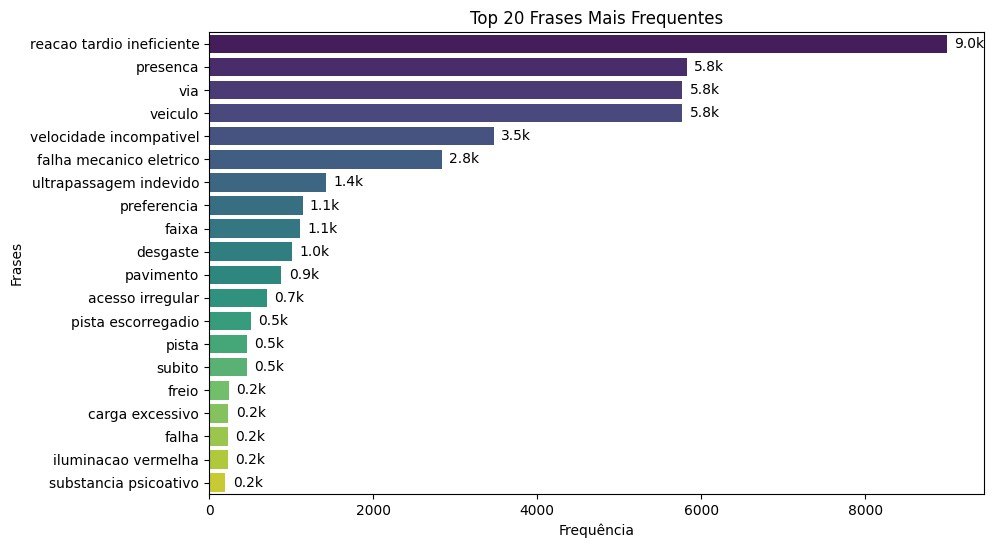

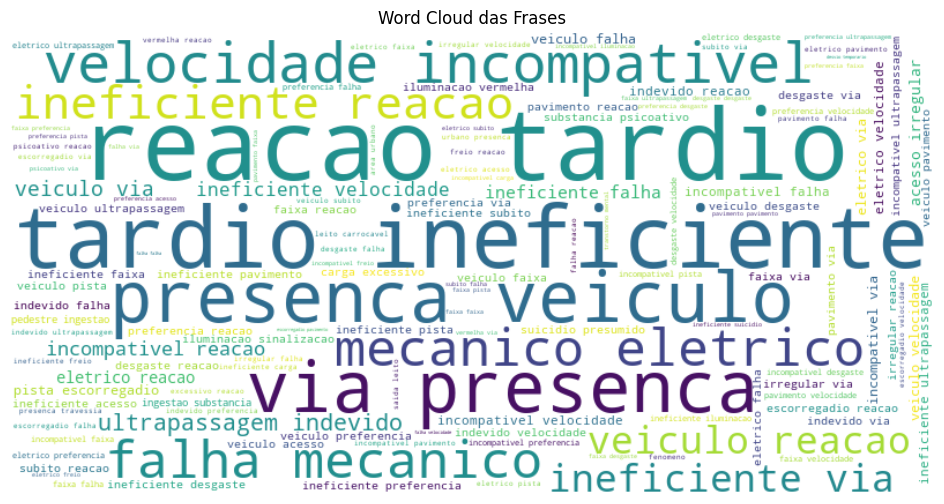

In [20]:
# Análise de texto das causas dos acidentes
plot_frases(todas_frases)

C:\Users\marci\AppData\Local\Temp\ipykernel_22244\3374294824.py:83: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.barplot(


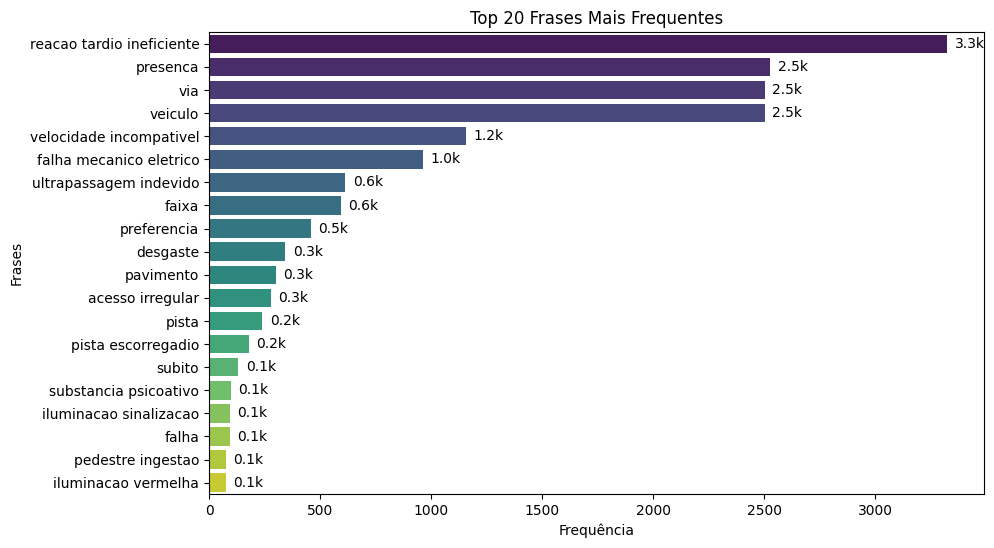

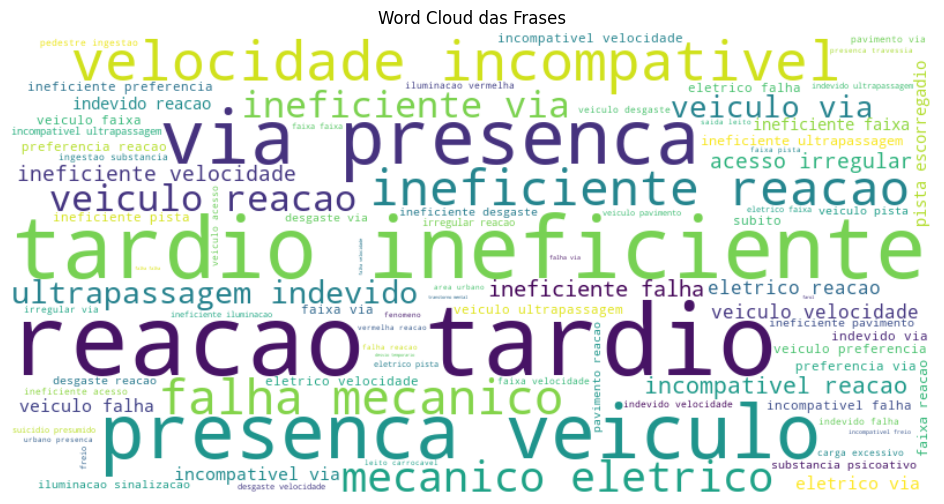

In [ ]:
# Filtrar DataFrame para horas críticas
horas_criticas = [5, 6, 7, 17, 18, 19, 20]
df_horas_criticas = df[df['HORA'].isin(horas_criticas)]

textos_horas_criticas = df_horas_criticas['CAUSA_ACIDENTE'].dropna().tolist()
frases_horas_criticas = []
for texto in textos_horas_criticas:
    frases_horas_criticas.extend(extrair_frases(texto))

plot_frases(frases_horas_criticas)


# 4.0 Análise de Traçado de via

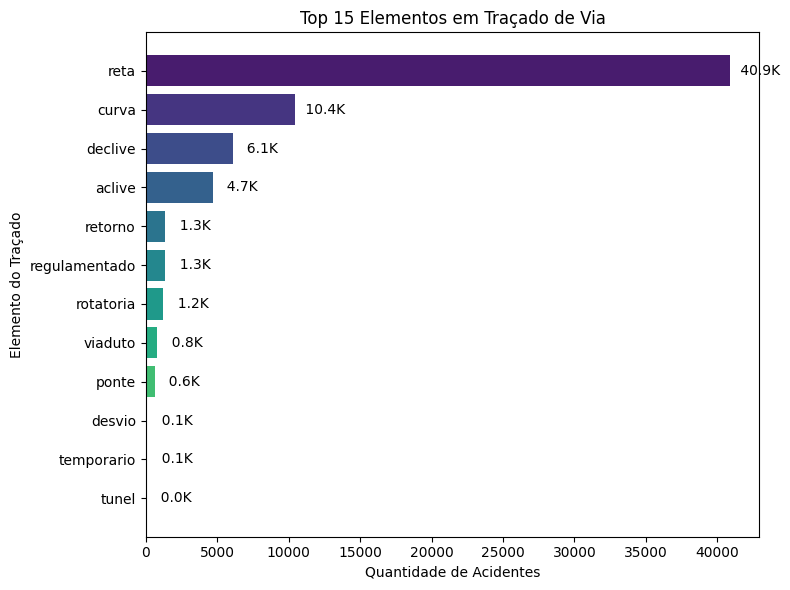

In [ ]:
# Análise de texto do traçado de via
df_tracado = df.dropna(subset=["TRACADO_VIA"]).copy()
df_tracado["TRAC_LIST"] = df_tracado["TRACADO_VIA"].str.lower().str.split("_")

# Removendo em e de do dataframe
df_tracado = df_tracado[~df_tracado["TRAC_LIST"].apply(lambda x: "em" in x or "de" in x)]

todos_tokens = list(chain.from_iterable(df_tracado["TRAC_LIST"]))
freq_tokens = (
    pd.Series(todos_tokens)
      .value_counts()
      .reset_index()
      .rename(columns={"index": "elemento", 0: "count"})
)

TOP_N = 15
top_elem = freq_tokens.head(TOP_N)

plt.figure(figsize=(8,6))
bars = plt.barh(top_elem["elemento"], top_elem["count"], color=sns.color_palette("viridis", len(top_elem)))
plt.gca().invert_yaxis()
plt.xlabel("Quantidade de Acidentes")
plt.ylabel("Elemento do Traçado")
plt.title(f"Top {TOP_N} Elementos em Traçado de Via")

for bar in bars:
  width = bar.get_width()
  label = f"{width/1000:5.1f}K"
  plt.text(width + max(top_elem["count"])*0.01, bar.get_y() + bar.get_height()/2,
       label, va='center', fontsize=10)

plt.tight_layout()
plt.show()


C:\Users\marci\AppData\Local\Temp\ipykernel_22244\485610643.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_pairs[["A","B"]] = top_pairs["par"].str.split("|", expand=True)
C:\Users\marci\AppData\Local\Temp\ipykernel_22244\485610643.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_pairs[["A","B"]] = top_pairs["par"].str.split("|", expand=True)


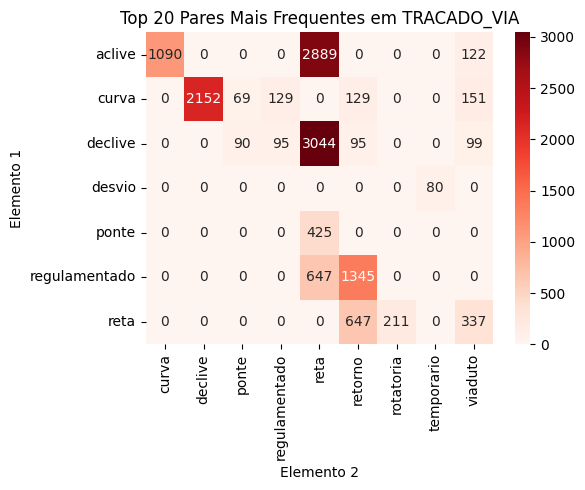

In [ ]:
# Gerar todos os pares (ordem não importa), apenas linhas com >=2 tokens
pair_list = []
for tokens in df_tracado["TRAC_LIST"]:
    if len(tokens) >= 2:
        for a, b in combinations(sorted(tokens), 2):
            pair_list.append(f"{a}|{b}")

pair_series = pd.Series(pair_list)
pair_counts = (
    pair_series.value_counts()
               .reset_index()
               .rename(columns={"index": "par", "count": "qtd"})
)

TOP_PARES = 20
top_pairs = pair_counts.head(TOP_PARES)
top_pairs[["A","B"]] = top_pairs["par"].str.split("|", expand=True)

heat_df = top_pairs.pivot(index="A", columns="B", values="qtd").fillna(0)

plt.figure(figsize=(6,5))
sns.heatmap(heat_df, annot=True, cmap="Reds", fmt="g")
plt.title(f"Top {TOP_PARES} Pares Mais Frequentes em TRACADO_VIA")
plt.ylabel("Elemento 1")
plt.xlabel("Elemento 2")
plt.tight_layout()
plt.show()
